# Supervised Learning

**Supervised learning** methods are applied directly to the event-level data to
predict the next blood glucose measurement based on recent management actions and physiological context.
By framing each glucose measurement as a prediction target and using preceding insulin, meal, exercise,
and glucose events within a fixed lookback window as input features, the task evaluates
how well short-term glucose dynamics can be inferred from logged behavioral sequences.

In [3]:
!uv pip install \
  "fastparquet>=2025.12.0" \
  "ipykernel>=7.2.0" \
  "llvmlite>=0.42" \
  "matplotlib>=3.10.8" \
  "numba>=0.59" \
  "numpy>=2.3.5" \
  "pandas==2.3.3" \
  "scikit-learn>=1.8.0" \
  "scipy>=1.17.0" \
  "seaborn>=0.13.2"

Using Python 3.12.12 environment at: /Users/z.yang/playground/srh-stat-and-ml-exam/.venv
Audited 10 packages in 6ms


In [4]:
from pathlib import Path

ROOT_DIR = Path().resolve().parent
DATA_DIR = ROOT_DIR / "data"

In [5]:
import pandas as pd

pd.set_option("future.no_silent_downcasting", True)
pd.set_option('display.max_columns', None)

In [6]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=SyntaxWarning)

## Data Splitting

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Split into training (80%), validation (10%), testing (10%)
df = pd.read_parquet(DATA_DIR / "processed" / "supervised" / "diabetes_next_glucose_supervised.parquet")
df_train, df_val_test = train_test_split(
    df,
    train_size=0.8,
    random_state=42)
df_val, df_test = train_test_split(
    df_val_test,
    train_size=0.5,
    random_state=42)

print(f"Shape of df_train: {df_train.shape}")
print(f"Shape of df_val: {df_val.shape}")
print(f"Shape of df_test: {df_test.shape}")

SAMPLE_DIR = DATA_DIR / "processed" / "supervised" / "samples"
SAMPLE_DIR.mkdir(parents=True, exist_ok=True)
df_train.to_parquet(SAMPLE_DIR / "train.parquet")
df_val.to_parquet(SAMPLE_DIR / "val.parquet")
df_test.to_parquet(SAMPLE_DIR / "test.parquet")

Shape of df_train: (8489, 30)
Shape of df_val: (1061, 30)
Shape of df_test: (1062, 30)


## Preprocessing

In [20]:
df_train

,id,event_time,target_time,delta_t_minutes,y_next_glucose,hour_of_day,day_of_week,is_weekend,is_paper_like_time_flag,bg_last_value,bg_window_count,bg_window_mean,bg_window_std,bg_window_min,bg_window_max,bg_window_range,time_since_last_bg,ins_window_count,ins_window_sum,ins_window_mean,ins_window_std,ins_window_max,time_since_last_ins,ins_33_sum,ins_34_sum,ins_35_sum,meal_events_count,exercise_events_count,hypo_event_flag,special_event_flag
8273,data-56,1989-03-03 18:00:00,1989-03-03 22:00:00,240,63.0,18,4,False,True,172.0,1,172.0,0.0,172.0,172.0,0.0,0,1,5.0,5.0,0.000000,5.0,0.0,5.0,0.0,0.0,0,0,False,False
9315,data-63,1991-07-28 07:11:00,1991-07-28 12:31:00,320,341.0,7,6,True,False,84.0,1,84.0,0.0,84.0,84.0,0.0,0,0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,False,False
7874,data-55,1991-05-22 12:00:00,1991-05-22 18:00:00,360,212.0,12,2,False,True,201.0,1,201.0,0.0,201.0,201.0,0.0,0,1,8.0,8.0,0.000000,8.0,0.0,8.0,0.0,0.0,0,0,False,False
1482,data-16,1991-07-11 08:56:00,1991-07-11 19:05:00,609,182.0,8,3,False,False,246.0,1,246.0,0.0,246.0,246.0,0.0,0,0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,False,False
7581,data-55,1991-03-10 18:00:00,1991-03-10 22:00:00,240,167.0,18,6,True,True,187.0,1,187.0,0.0,187.0,187.0,0.0,0,1,10.0,10.0,0.000000,10.0,0.0,10.0,0.0,0.0,0,0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,data-42,1991-09-01 08:00:00,1991-09-01 12:00:00,240,182.0,8,6,True,True,49.0,1,49.0,0.0,49.0,49.0,0.0,0,1,2.0,2.0,0.000000,2.0,0.0,2.0,0.0,0.0,0,0,False,False
5191,data-39,1991-07-18 12:10:00,1991-07-18 18:05:00,355,161.0,12,3,False,False,104.0,1,104.0,0.0,104.0,104.0,0.0,0,0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0,0,False,False
5390,data-41,1991-01-20 22:00:00,1991-01-21 08:00:00,600,96.0,22,6,True,True,140.0,1,140.0,0.0,140.0,140.0,0.0,0,1,5.0,5.0,0.000000,5.0,0.0,0.0,5.0,0.0,0,0,False,False
860,data-07,1989-04-28 08:00:00,1989-04-28 12:00:00,240,126.0,8,4,False,True,215.0,1,215.0,0.0,215.0,215.0,0.0,0,2,25.0,12.5,7.778175,18.0,0.0,7.0,18.0,0.0,0,0,False,False


### Handle missing values

In [19]:
cols_with_nan = df_train.columns[df.isna().any()]
print(f"columns with NaN: {cols_with_nan.tolist()}")

nan_counts = df.isna().sum()
print(f"NaN counts: \n{nan_counts[nan_counts > 0]}")

columns with NaN: ['ins_window_mean', 'ins_window_std', 'ins_window_max', 'time_since_last_ins']
NaN counts: 
ins_window_mean        5474
ins_window_std         5474
ins_window_max         5474
time_since_last_ins    5474
dtype: int64


Although the columns listed above contain a large number of missing values, this is expected for diabetes treatment behavior data, where the absence of insulin usage on certain days is a normal scenario. Since the columns with missing values are all derived statistical features, we fill them with zeros rather than discarding the data.

### Noise Injection & Cleaning

In [23]:
# Calculate the range of `bg_last_value`.
df_train["bg_last_value"].describe()

count    8489.000000
mean      158.248557
std        81.435289
min        19.000000
25%        94.000000
50%       145.000000
75%       210.000000
max       501.000000
Name: bg_last_value, dtype: float64

In [25]:
# Synthetic outliers were injected into 1% of samples to evaluate robustness.
import numpy as np

rng = np.random.default_rng(42)

df_train_with_noise = df_train.copy()

k = int(0.01 * len(df_train_with_noise))
idx = rng.choice(df_train_with_noise.index, k, replace=False)

df_train_with_noise.loc[idx[: k // 2], "bg_last_value"] = np.random.uniform(1, 18, k // 2)
df_train_with_noise.loc[idx[k // 2 :], "bg_last_value"] = np.random.uniform(502, 700, k - k // 2)

In [26]:
((df_train_with_noise["bg_last_value"] < 19) | (df_train_with_noise["bg_last_value"] > 501)).mean()

np.float64(0.009895158440334551)

In [27]:
# Denoising
df_train_denoised = df_train_with_noise.copy()
col = "bg_last_value"

q1 = df_train_denoised[col].quantile(0.25)
q3 = df_train_denoised[col].quantile(0.75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

df_train_denoised[col] = df_train_denoised[col].clip(lower, upper)

In [28]:
print("Before denoise:")
print(df_train_with_noise[col].describe())

print("\nAfter denoise:")
print(df_train_denoised[col].describe())

Before denoise:
count    8489.000000
mean      159.679747
std        87.433227
min         1.223858
25%        93.000000
50%       146.000000
75%       211.000000
max       679.395236
Name: bg_last_value, dtype: float64

After denoise:
count    8489.000000
mean      158.343461
std        82.338514
min         1.223858
25%        93.000000
50%       146.000000
75%       211.000000
max       388.000000
Name: bg_last_value, dtype: float64


## Statistical Analysis

In [29]:
# Essential descriptive statistics
num_df = df_train_denoised.select_dtypes(include="number")

stats = pd.DataFrame({
    "mean": num_df.mean(),
    "variance": num_df.var(),
    "skewness": num_df.skew()
})

stats.head()

,mean,variance,skewness
delta_t_minutes,369.219107,22298.529508,0.484662
y_next_glucose,157.361644,6470.285550,0.727134
hour_of_day,13.994110,33.936582,-0.037388
day_of_week,2.923548,4.013594,0.056164
bg_last_value,158.343461,6779.630921,0.665877


In [30]:
# Correlation
corr = num_df.corr()
corr.head()

,delta_t_minutes,y_next_glucose,hour_of_day,day_of_week,bg_last_value,bg_window_count,bg_window_mean,bg_window_std,bg_window_min,bg_window_max,bg_window_range,time_since_last_bg,ins_window_count,ins_window_sum,ins_window_mean,ins_window_std,ins_window_max,time_since_last_ins,ins_33_sum,ins_34_sum,ins_35_sum,meal_events_count,exercise_events_count
delta_t_minutes,1.000000,0.084461,0.300348,-0.010055,0.057597,0.073344,0.052796,0.068899,0.036203,0.065514,0.067089,NaN,-0.123358,-0.171805,-0.238994,-0.059213,-0.185592,0.336428,-0.186417,-0.078952,-0.091802,0.008205,0.048878
y_next_glucose,0.084461,1.000000,0.066649,0.065560,0.171309,0.015303,0.177584,0.043529,0.164583,0.180829,0.043890,NaN,0.016061,0.017142,0.019299,-0.038475,-0.002559,0.057805,0.084478,-0.051982,0.028977,0.031551,-0.013347
hour_of_day,0.300348,0.066649,1.000000,0.002737,0.003093,0.147731,0.001616,0.120467,-0.025947,0.028362,0.119988,NaN,-0.205663,-0.324558,-0.463840,-0.547195,-0.551152,0.366666,-0.073351,-0.292661,-0.232371,0.032201,0.091410
day_of_week,-0.010055,0.065560,0.002737,1.000000,0.068363,0.013137,0.077916,0.015395,0.073039,0.078054,0.014582,NaN,0.018017,0.030355,0.041261,-0.001947,0.030352,0.019848,0.044262,0.007998,0.013985,-0.024243,0.000953
bg_last_value,0.057597,0.171309,0.003093,0.068363,1.000000,-0.023760,0.940363,0.038166,0.917311,0.914968,0.037340,NaN,0.080532,0.125031,0.183778,0.078861,0.160827,-0.027385,0.163952,0.017873,0.093369,0.013190,-0.030024


In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

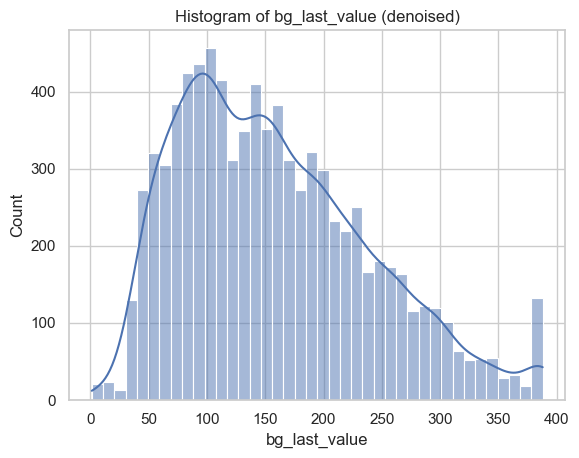

In [35]:
# Histogram
plt.figure()
sns.histplot(df_train_denoised["bg_last_value"], bins=40, kde=True)
plt.title("Histogram of bg_last_value (denoised)")
plt.xlabel("bg_last_value")
plt.ylabel("Count")
plt.show()

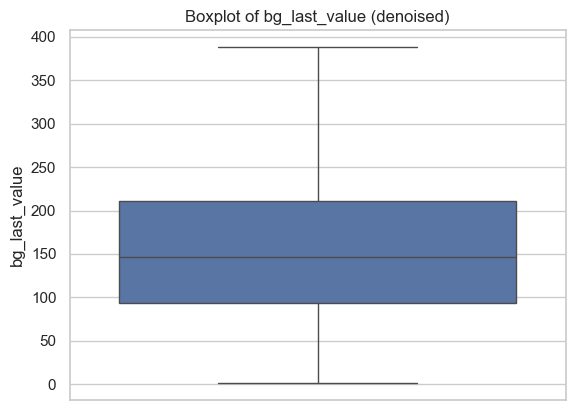

In [36]:
# Boxplot
plt.figure()
sns.boxplot(y=df_train_denoised["bg_last_value"])
plt.title("Boxplot of bg_last_value (denoised)")
plt.ylabel("bg_last_value")
plt.show()

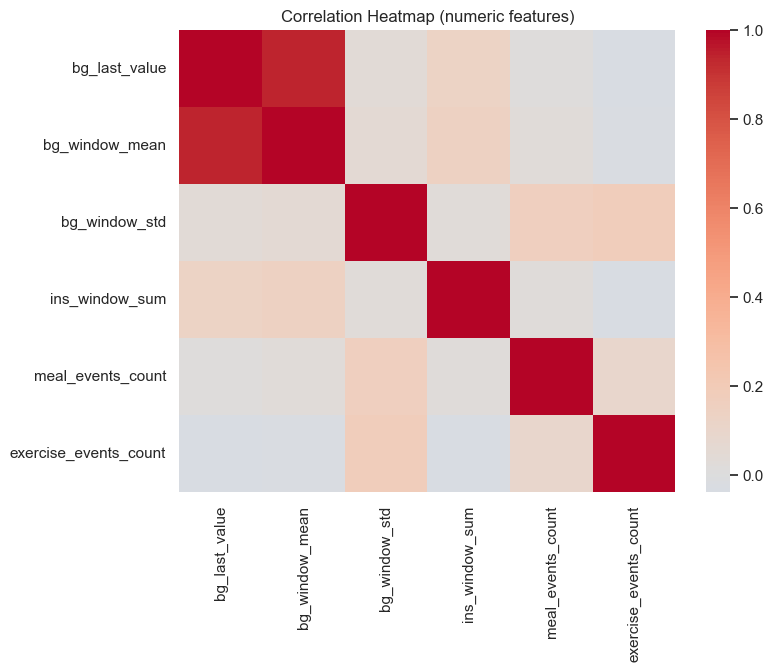

In [39]:
# Correlation heatmap
num_df = df_train_denoised.select_dtypes(include="number")
cols = [
    "bg_last_value",
    "bg_window_mean",
    "bg_window_std",
    "ins_window_sum",
    "meal_events_count",
    "exercise_events_count",
]

plt.figure(figsize=(8, 6))
sns.heatmap(num_df[cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (numeric features)")
plt.show()

Descriptive statistics were complemented with visual analysis using histograms, boxplots, and correlation heatmaps to examine the distributional properties and relationships among numerical features after denoising.

## Regression Model

In [51]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
DROP_COLS = ["id", "event_time", "target_time", "delta_t_minutes"]
TARGET = "y_next_glucose"

ZERO_FILL_COLS = [
    "ins_window_mean",
    "ins_window_std",
    "ins_window_max",
    "time_since_last_ins",
]

CATEGORICAL_COLS = ["hour_of_day", "day_of_week"]

In [55]:
def build_pipeline(df):
    X = df.drop(columns=DROP_COLS + [TARGET])

    # numeric columns excluding the categorical time cols
    numeric_cols = X.select_dtypes(include="number").columns.tolist()
    numeric_cols = [c for c in numeric_cols if c not in CATEGORICAL_COLS]

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("scaler", MinMaxScaler()),
    ])

    cat_pipe = Pipeline([
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, numeric_cols),
            ("cat", cat_pipe, CATEGORICAL_COLS),
        ],
        remainder="drop",
    )

    rf = RandomForestRegressor(
        n_estimators=400,
        random_state=42,
        n_jobs=-1,
        min_samples_leaf=2,
    )

    return Pipeline([
        ("prep", pre),
        ("rf", rf),
    ])

In [56]:
def train_and_evaluate(df_train, df_val, name=""):
    X_train = df_train.drop(columns=DROP_COLS + [TARGET])
    y_train = df_train[TARGET]

    X_val = df_val.drop(columns=DROP_COLS + [TARGET])
    y_val = df_val[TARGET]

    pipe = build_pipeline(df_train)
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    print(f"{name} | RMSE: {rmse:.3f}, R2: {r2:.3f}")
    return pipe, y_val, y_pred

In [57]:
pipe_noise, y_val, y_pred_noise = train_and_evaluate(df_train_with_noise, df_val, name="RF (With Noise)")
pipe_denoised, _, y_pred_denoised = train_and_evaluate(df_train_denoised, df_val, name="RF (Denoised)")

RF (With Noise) | RMSE: 77.269, R2: 0.102
RF (Denoised) | RMSE: 77.204, R2: 0.104


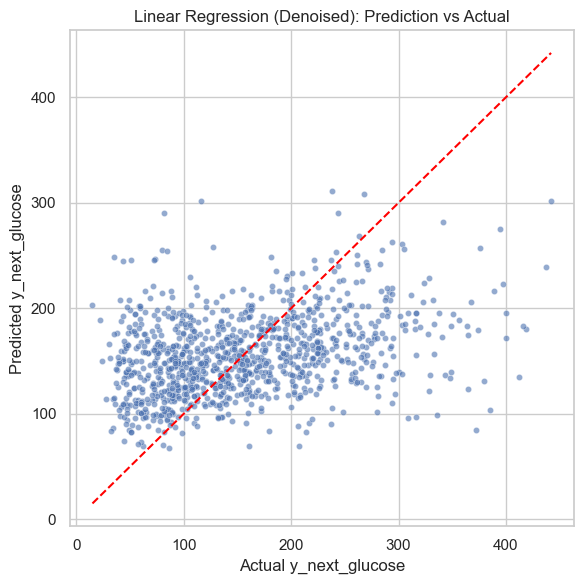

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_val, y=y_pred_denoised, s=20, alpha=0.6)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         color="red", linestyle="--")
plt.xlabel("Actual y_next_glucose")
plt.ylabel("Predicted y_next_glucose")
plt.title("Linear Regression (Denoised): Prediction vs Actual")
plt.tight_layout()
plt.show()

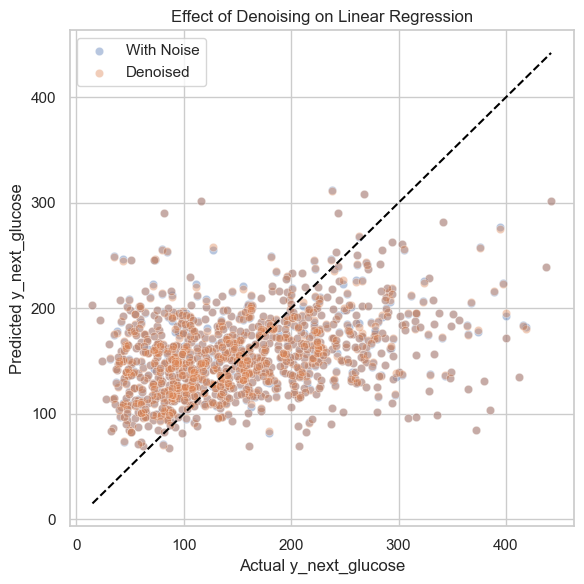

In [59]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_val, y=y_pred_noise, label="With Noise", alpha=0.4)
sns.scatterplot(x=y_val, y=y_pred_denoised, label="Denoised", alpha=0.4)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         color="black", linestyle="--")
plt.legend()
plt.xlabel("Actual y_next_glucose")
plt.ylabel("Predicted y_next_glucose")
plt.title("Effect of Denoising on Linear Regression")
plt.tight_layout()
plt.show()

In [60]:
X_test = df_test.drop(columns=DROP_COLS + [TARGET])
y_test = df_test[TARGET]

y_test_pred = pipe_denoised.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print(f"Test | RMSE: {rmse_test:.3f}, R2: {r2_test:.3f}")

Test | RMSE: 74.300, R2: 0.118


A random forest regression model was trained to predict the next blood glucose value. Missing values in selected insulin-related features were imputed with zeros, categorical time features were one-hot encoded, and all numerical features were scaled using min–max normalization. Model performance was evaluated using RMSE and R², and prediction–actual plots were used to visualize regression quality. A comparison between noisy and denoised training data highlights the effect of outlier handling on model stability.

## Conclusion

With `n_estimators = 400` and `min_samples_leaf = 2`, a Random Forest regressor was applied to predict the next blood glucose value using event-window features. The model achieved moderate performance, with an RMSE of approximately 77 on the validation set and 74 on the test set, and R² values around 0.10–0.12. IQR-based denoising led to a small but consistent improvement, indicating limited sensitivity to extreme values. The prediction–actual plots show that the model captures some non-linear structure but still tends to regress toward the mean, suggesting that short-term glucose dynamics remain difficult to model with the current feature representation.